# Przygotowywanie danych

### Pobieranie bazy danych

In [ ]:
#instalacja pakietu gdown
%pip install -U --no-cache-dir gdown==4.6.0 --pre
#usuwanie i tworzenie pustego katalogu data
!rm -rf data && mkdir data
#pobieranie zip-a ze zdjęciami
!gdown 17-BSZPMXiS6RiD3YQM2NN3ZQecu0vt2X -O data.zip
#rozpakowywanie pliku data.zip do katalogu data
!unzip -q data.zip -d data

  Attempting uninstall: gdown
    Found existing installation: gdown 5.2.0
    Uninstalling gdown-5.2.0:
      Successfully uninstalled gdown-5.2.0
Downloading...
From: https://drive.google.com/uc?id=17-BSZPMXiS6RiD3YQM2NN3ZQecu0vt2X
To: /content/data.zip
100% 67.6M/67.6M [00:03<00:00, 20.6MB/s]


### Importowanie niezbędnych bibliotek

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import glob

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model

## Badanie zawartości bazy danych

### Weryfikowanie wielkości bazy danych  

In [ ]:
image_count = len(list(glob.glob('data/**/**/*.jpg')))
print(f'{image_count} examples of dogs and cats')

697 examples of dogs and cats


### Weryfikowanie rozkładu klas w bazie danych  

In [ ]:
dogs_count = len(list(glob.glob('data/**/dogs/*.jpg')))
cats_count = len(list(glob.glob('data/**/cats/*.jpg')))
print(f'{dogs_count} examples of dogs and {cats_count} cats to train')

348 examples of dogs and 349 cats to train


### Wyświetlanie przykładowych zdjęć

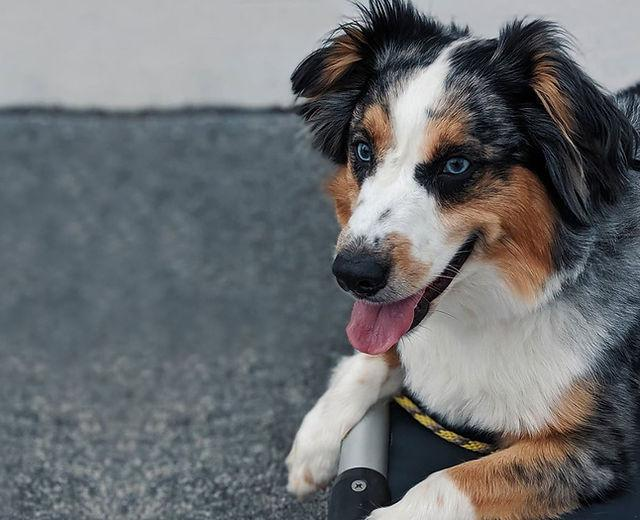

In [ ]:
dogs = list(glob.glob('data/train/dogs/*'))
PIL.Image.open(str(dogs[3]))

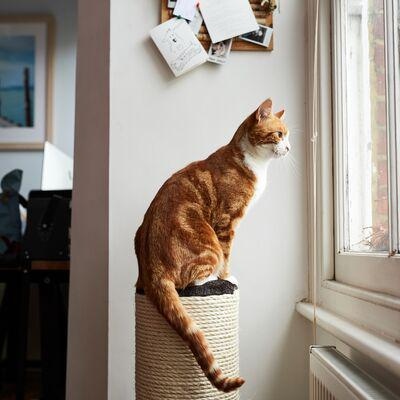

In [ ]:
cats = list(glob.glob('data/train/cats/*'))
PIL.Image.open(str(cats[0]))

# Trenowanie modelu sieci neuronowej

### Zmienne niezbędne do trenowania modelu

In [ ]:
batch_size = 32
class_count = 2

img_height = 64
img_width = 64

### Ładowanie bazy danych wykorzystywanej do trenowania modelu

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'data/train',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 557 files belonging to 2 classes.


### Ładowanie bazy danych wykorzystywanej do testowania wydajności modelu podczas uczenia

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  'data/test',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 140 files belonging to 2 classes.


### Wyświetlenie nazwy klas występujących w bazie danych

In [ ]:
class_names = train_ds.class_names
print(f'class names: {class_names}')

class names: ['cats', 'dogs']


Drobne ustawienia optymalizacyjne

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### Tworzenie struktury modelu sieci neuronowej

In [ ]:
def get_model(type='custom'):
  model = None
  if type == 'resnet_transfer':
    base_model = tf.keras.applications.ResNet50(
            include_top=False,
            input_shape=(img_height, img_width, 3),
            classes=class_count,
        )
    x = layers.GlobalAveragePooling2D()(base_model.output)

    # Add a fully connected layer with a sigmoid activation for binary classification
    predictions = layers.Dense(class_count, activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

  elif type == 'resnet':
    model = tf.keras.applications.ResNet50(
            weights=None,
            input_shape=(img_height, img_width, 3),
            classes=class_count,
        )

  elif type == 'custom':
    model = Sequential([
      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(class_count)
    ])

  return model


### Kompilowanie modelu oraz wyświetlanie jego struktury

In [ ]:
model = get_model('custom')
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 548,258 (2.09 MB)

 Trainable params: 548,258 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

### Uruchomienie procesu trenowania

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 261ms/step - accuracy: 0.5325 - loss: 0.7629 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5128 - loss: 0.6891 - val_accuracy: 0.5571 - val_loss: 0.6897
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5880 - loss: 0.6827 - val_accuracy: 0.5357 - val_loss: 0.7045
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5674 - loss: 0.6829 - val_accuracy: 0.6286 - val_loss: 0.6865
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6360 - loss: 0.6275 - val_accuracy: 0.6357 - val_loss: 0.6580
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7342 - loss: 0.5852 - val_accuracy: 0.6714 - val_loss: 0.6569
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7291 - loss: 0.5406 - val_accuracy: 0.6786 - val_loss: 0.7000
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7531 - loss: 0.4754 - val_accuracy: 0.5714 - val_los

# Ocena wytrenowanego modelu

### Wyświetlenie przebiegu procesu trenowania

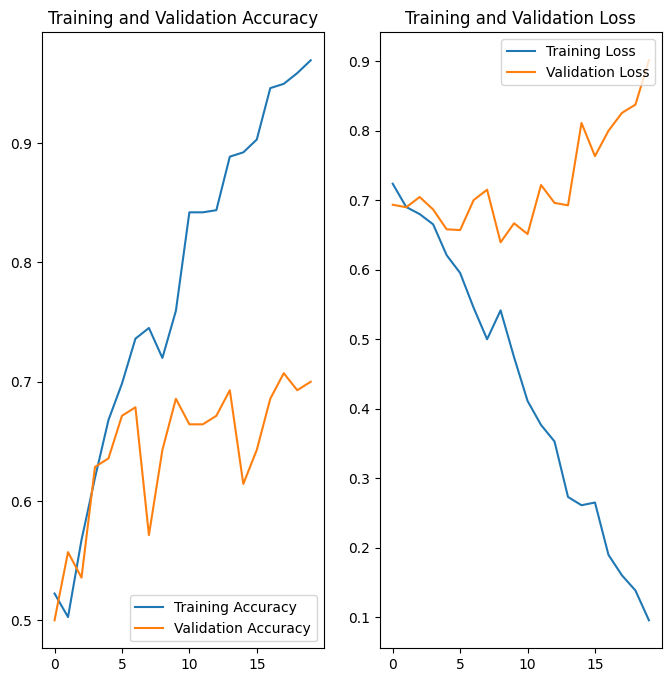

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Raport dotyczący jakości klasyfikacji

In [ ]:
from sklearn.metrics import classification_report
def evaluate_model(val_ds, model):
    y_pred = []
    y_true = []

    for batch_images, batch_labels in val_ds:
        predictions = model.predict(batch_images, verbose=0)
        y_pred = y_pred + np.argmax(tf.nn.softmax(predictions), axis=1).tolist()
        y_true = y_true + batch_labels.numpy().tolist()
    print(classification_report(y_true, y_pred))

evaluate_model(val_ds, model)

              precision    recall  f1-score   support

           0       0.76      0.59      0.66        70
           1       0.66      0.81      0.73        70

    accuracy                           0.70       140
   macro avg       0.71      0.70      0.70       140
weighted avg       0.71      0.70      0.70       140



# Zadania do wykonania
1. Wytrenuj model zmieniając hiperparametr `batch_size` - zobacz jak to wpłynęło na wyniki klasyfikatora.
2. Wytrenuj model zmieniając hiperparametr `img_height` i `img_width` - zobacz jak to wpłynęło na wyniki klasyfikatora.
3. Wytrenuj model na strukturze resnet50 z transfer learningiem - zobacz jak to wpłynęło na wyniki klasyfikatora.
4. Wytrenuj model na strukturze resnet50 z bez transfer learningu
 zobacz jak to wpłynęło na wyniki klasyfikatora.
5. Wytrenuj model na zmienionej strukturze (np. zmiana rozmiaru konwolucji) "custom" - zobacz jak to wpłynęło na wyniki klasyfikatora.